In [1]:
import matplotlib.pyplot as plt
from CODE.utils import *
from CODE.models import create_2f_model
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
window_size = 10
n_units = 256
corr_threshold = 0.2

df = load_dfs()
diff_df = df.pct_change(1).iloc[1:,:]

correlations = diff_df.corr().values[0]
filteres_ids = np.argwhere(abs(correlations)> corr_threshold).flatten()
diff_df = diff_df.iloc[:,filteres_ids]
print(diff_df.head())

                AAON      ABMD      ACIW      ADTN     ANSS      ATNI  \
Date                                                                    
2000-05-08  0.017883  0.020289  0.003582 -0.053763  0.00000  0.006400   
2000-05-09 -0.002849 -0.062857 -0.022011  0.024697 -0.02439 -0.012821   
2000-05-10 -0.026667 -0.018293 -0.030414 -0.070235  0.00000 -0.012987   
2000-05-11 -0.002935  0.001491  0.000000  0.079517  0.00000  0.000000   
2000-05-12 -0.030913 -0.016869 -0.039523 -0.049794  0.05000  0.026316   

                ATVI      FLWS      MSFT      SRCE      UHAL  
Date                                                          
2000-05-08  0.017639 -0.025793 -0.018420 -0.003477  0.010216  
2000-05-09 -0.029333 -0.017698 -0.028649 -0.002991 -0.007139  
2000-05-10 -0.157967  0.026953 -0.023890 -0.031000 -0.011384  
2000-05-11  0.101142  0.000000  0.025381 -0.006708  0.003636  
2000-05-12  0.019259 -0.017544  0.013850  0.012987  0.007850  


In [3]:

file = 'FILES/Models/lstm_2f_model.hdf5'
rf_num = diff_df.values.shape[1]
input_shape = (window_size,rf_num)
model = create_2f_model(n_units, input_shape, file)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 546816      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional[0][2]          

In [4]:
X1, X2, Y = generate_windows_for_two_factor(diff_df, window_size)
batch_size = 512
n_train = len(X1)//batch_size
X_train = [X1[0:n_train*batch_size], X2[0:n_train*batch_size]]
Y_train = Y[0:n_train*batch_size]
generator = TwoFactorGenerator(X_train, Y_train, batch_size=batch_size)
X_val = [X1[n_train*batch_size:], X2[n_train*batch_size:]]
Y_val = Y[n_train*batch_size:]


In [5]:
epochs = 100
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from time import time
file = 'FILES/Models/lstm_2f_model.hdf5'
model_checkpoint = ModelCheckpoint(file, save_best_only=True,  monitor='val_loss', verbose=0, save_weights_only=True)
#tensor_board = TensorBoard(log_dir='./LOGS', histogram_freq=1)
tensor_board = TensorBoard(log_dir='LOGS\{}'.format(time()), histogram_freq=1)
early_stop = EarlyStopping(patience=10)
model.fit_generator(generator, 
                    steps_per_epoch=1, 
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, Y_val),
                    callbacks=[model_checkpoint, tensor_board, early_stop])


W0321 13:52:08.926857 18556 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.841254). Check your callbacks.


In [6]:
start = 100
window = 100
test_df = df.iloc[1000:1300,0].to_frame()
test_df.columns=['Actual']
test_df['Interp'] = test_df.iloc[:,0]
test_df['Interp'].iloc[start:start+window]=np.nan
test_df = test_df.interpolate()
start_value = test_df.iloc[start-1,0]
end_value = test_df.iloc[start+window,0]

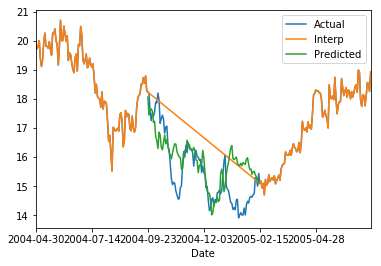

In [7]:
file = 'FILES/Models/lstm_2f_model.hdf5'
rf_num = diff_df.values.shape[1]
input_shape = (window_size,rf_num)
model = create_2f_model(n_units, input_shape, file)

Y_pred, Y_actual=list(), list()
for id in range(start, start+window):
    if id == start:
        x2 = X2[id].reshape(-1, window_size - 1, 1)
    x1 = X1[id].reshape(-1,window_size,input_shape[1]-1)
    Y_pred.append(model.predict([x1, x2]).flatten())
    Y_actual.append(Y[id].flatten())
    x2[0, :-1, 0] = x2[0, 1:, 0]
    x2[0,-1,0] = Y_pred[-1][-1]

test_df['Predicted']=np.nan
fixed_values = np.array(Y_pred)+1
for i, value in enumerate(fixed_values):
    if i == 0:
        fixed_values[0]=value*start_value
    else:
        fixed_values[i]=fixed_values[i-1]*value
multiplier = end_value/fixed_values[-1]
singlemultipliers = np.array([multiplier**(x/(window+1)) for x in range(window+2)])
#singlemultipliers = np.array([multiplier**(0) for x in range(window+2)])
test_df['Predicted'].iloc[start:start+100]=fixed_values[:, 0]*singlemultipliers[:-2, 0]
test_df.plot()


In [8]:
import matplotlib.pyplot as plt
compare_df = test_df.dropna().copy()
compare_df['LinInterpDiffs']=abs(compare_df['Actual']-compare_df['Interp'])/compare_df['Actual']
compare_df['LstmPredDiffs']=abs(compare_df['Actual']-compare_df['Predicted'])/compare_df['Actual']
print(compare_df.head())

            Actual     Interp  Predicted  LinInterpDiffs  LstmPredDiffs
Date                                                                   
2004-09-23   18.25  18.228713  18.060358        0.001166       0.010391
2004-09-24   18.18  18.197426  17.446648        0.000959       0.040338
2004-09-27   17.55  18.166139  17.569847        0.035108       0.001131
2004-09-28   17.25  18.134851  17.656567        0.051296       0.023569
2004-09-29   17.52  18.103564  17.581274        0.033308       0.003497


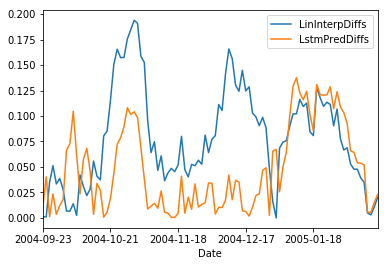

In [9]:
compare_df.loc[:,['LinInterpDiffs', 'LstmPredDiffs'] ].plot()

In [10]:
print("Lstm Average Error: {}".format(compare_df['LstmPredDiffs'].mean()))
print("Interpolation Average Error: {}".format(compare_df['LinInterpDiffs'].mean()))

Lstm Average Error: 0.04833166260403367
Interpolation Average Error: 0.0784135736903017


In [11]:
from scipy import stats

resLstm = stats.ks_2samp(compare_df['Actual'].values, compare_df['Predicted'].values)
print("Lstm KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resLstm.statistic, resLstm.pvalue))
resInterp = stats.ks_2samp(compare_df['Actual'].values, compare_df['Interp'].values)
print("Interp KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resInterp.statistic, resInterp.pvalue))

Lstm KS result: 
 	 - Statistic: 0.37 
 	 - pvalue: 1.3347399942910654e-06
Interp KS result: 
 	 - Statistic: 0.51 
 	 - pvalue: 3.696390026378737e-12
